In [44]:
import os
import sys
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from imageio import imread
import json
import torch
torch.cuda.empty_cache()

from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

current_dir = os.path.dirname(os.path.realpath('__file__'))
import utils
from utils import plot_3d_slices
from utils import set_seeds
from utils import set_device
#from utils import get_optimizer_nn
from utils import init_weights_xavier
from utils import get_patch_size,generate_rgb_array
from utils import Log
data_dir = os.path.join(current_dir, 'data')

from training_pipnet_LR import get_network,get_optimizer_nn
sys.path.append(data_dir)
#from make_dataset import get_dataloaders
import make_dataset_LR
from make_dataset_LR import get_dataloaders,getAllDataloader,getAllDataset
# Construct the path to the models directory
models_dir = os.path.join(current_dir, 'models')

# Add the models directory to sys.path
sys.path.append(models_dir)
from resnet_features import video_resnet18_features
from pipnet import PIPNet,NonNegLinear
from train_model_custom import train_pipnet

from test_model import eval_pipnet

vis_dir=os.path.join(current_dir, 'visualization')
sys.path.append(vis_dir)
import vis_pipnet
#from vis_pipnet import visualize, visualize_topk
from vis_pipnet import get_img_coordinates,plot_rgb_slices,plot_local_explanation
import plotly.graph_objects as go
import xarray as xr
import plotly.express as px

from scipy.ndimage import binary_erosion
from monai.transforms import (
    Compose,
    Resize,
    RandRotate,
    Affine,
    RandGaussianNoise,
    RandZoom,
    RepeatChannel,
)
import math
import joblib
import h5py
from importlib import reload


In [2]:

args={
    'log_dir':'logs/OPNorm9995_tan2_backbone1en4_fold2',
    'seed':44,
    'experiment_folder':'data/experiment_1',
    'lr':.0001,
    'lr_net':.0001,
    'lr_block':.0001,
    'lr_class':.0001,
    'lr_backbone':.0001,
    'weight_decay':0,
    'gamma':.1,
    'step_size':1,
    'batch_size':15,
    'epochs':160,
    'epochs_pretrain':30,
    'freeze_epochs':0,
    'epochs_finetune':10,
    'num_classes':2,
    'channels':3,
    'net':"3Dresnet18",
    'num_features':0,
    'bias':False,
    'out_shape':1,
    'disable_pretrained':False,
    'optimizer':'Adam',
    'state_dict_dir_net':'',
    "dic_classes":{False:0,True:1},
    'val_split':.05,
    'test_split':.2,
    'defaultFinetune':True,
    'lr_finetune':.05,
    'flipTrain':False,
    'stratSampling':True,
    'excludePatients':['735','322','531','523','876','552'],
    'log_power':1,
    'img_shape':[54,121,74],
    'wshape':5, # this is assigned mid script and doesn't matter here
    'hshape':8, # these matter and should bechanged to correct vals for the analyzing_network
    'dshape':7,
    'patchsize':15,
}

channels=3
aug_prob = 1
rand_rot = 10                       # random rotation range [deg]
rand_rot_rad = rand_rot*math.pi/180 # random rotation range [rad]
rand_noise_std = 0.01               # std random Gaussian noise
rand_shift = 5                      # px random shift
min_zoom = 0.9
max_zoom = 1.1
transforms_dic = {
    'train': Compose([
        RandRotate(range_x=rand_rot_rad, 
                    range_y=rand_rot_rad, 
                    range_z=rand_rot_rad, 
                    prob=aug_prob),
        RandGaussianNoise(std=rand_noise_std, prob=aug_prob),
        Affine(translate_params=(rand_shift,
                                    rand_shift,
                                    rand_shift), 
                image_only=True),
        RandZoom(min_zoom=min_zoom, max_zoom=max_zoom, prob=aug_prob),
        RepeatChannel(repeats=channels),
    ]),
    'train_noaug': Compose([RepeatChannel(repeats=channels)]),
    'project_noaug':Compose([RepeatChannel(repeats=channels)]),
    'val': Compose([RepeatChannel(repeats=channels)]),
    'test': Compose([RepeatChannel(repeats=channels)]),
    'test_projection': Compose([RepeatChannel(repeats=channels)]),
}

downSample=3.2
lowerBound=.15
#inputData=f'data/FP923_LR_avgCrop_DS{int(downSample*10)}_point{int(lowerBound*100)}Thresh.h5'
inputData=f'data/FP_LR_OPNorm_avgcrop_DS{int(downSample*10)}_point{int(lowerBound*100)}Thresh.h5'
with open(f"{args['log_dir']}/kMeans_DS32.json","r") as f:
    kMeansFold=json.load(f)

In [3]:
def sliceViewer(images,labels, key: str, title: str, height:int):
    if len(images.shape)==3:
        newIm=RepeatChannel(3)(images.unsqueeze(0))
        newIm=torch.moveaxis(newIm,[0,1,2,3],[-1,0,1,2])
    else:
        newIm=images
    xrData = xr.DataArray(
        data   = newIm,
        dims   = [key, 'row', 'col', 'rgb'],
        coords = {key: labels}
    )
    # Hide the axes
    #layout_dict = dict(yaxis_visible=False, yaxis_showticklabels=False, xaxis_visible=False, xaxis_showticklabels=False)
    layout_dict=dict()
    return px.imshow(xrData, title=title, animation_frame=key).update_layout(layout_dict)


In [4]:
useGPU=True
devID=0
if useGPU:
    device=torch.device(f'cuda:{devID}')
else:
    device=torch.device('cpu')
#yflags=pd.read_csv("../duke/ClinicalFlags.csv",index_col=0)


dataloaders=get_dataloaders(dataset_h5path=inputData,
                            k_fold=5,
                            test_p=.2,
                            val_p=.05,
                            batchSize=args['batch_size'],
                            seed=args['seed'],
                            kMeansSaveDir="data/kMeans_DS32.json")

trainloader = dataloaders[0]
trainloader_pretraining = dataloaders[1]
trainloader_normal = dataloaders[2] 
trainloader_normal_augment = dataloaders[3]
projectloader = dataloaders[4]
valloader = dataloaders[5]
testloader = dataloaders[6] 
test_projectloader = dataloaders[7]

allData=getAllDataset(inputData)
inputKeys=allData.subsetKeys

In [5]:
#arr,label=projectloader.dataset["109_R"]
arr,label=allData['109_R']
args['img_shape']=list(arr.shape[1:])
arr=RepeatChannel(repeats=3)(arr)
arr.shape



torch.Size([3, 54, 121, 74])

In [9]:
volume=arr
volumeRGB=np.moveaxis(volume,[0,1,2,3],[-1,0,1,2])

sliceViewer(volumeRGB,[i for i in range(len(volumeRGB))],key="Depth",title="test",height=700)

In [6]:
network_layers = get_network(num_classes=args['num_classes'], args=args)
feature_net = network_layers[0]
add_on_layers = network_layers[1]
pool_layer = network_layers[2]
classification_layer = network_layers[3]
num_prototypes = network_layers[4]
newFeatures=feature_net
net = PIPNet(
        num_classes = args['num_classes'],
        num_prototypes = num_prototypes,
        feature_net = newFeatures,
        args = args,
        add_on_layers = add_on_layers,
        pool_layer = pool_layer,
        classification_layer = classification_layer
        )
net = net.to(device=device)
net = nn.DataParallel(net, device_ids = [0])  

Number of prototypes:  512


In [7]:
optimizer = get_optimizer_nn(net, args)
optimizer_net = optimizer[0]
optimizer_classifier = optimizer[1] 
params_to_freeze = optimizer[2] 
params_to_train = optimizer[3] 
params_backbone = optimizer[4]   

Network is  3Dresnet18


In [8]:
checkpointFile=f"{args['log_dir']}/checkpoints/net_trained_last"
checkpoint = torch.load(checkpointFile, map_location = device)
net.load_state_dict(checkpoint['model_state_dict'], strict = True) 
net.module._multiplier.requires_grad = False
try:
    optimizer_net.load_state_dict(
        checkpoint['optimizer_net_state_dict']) 
except:
    print("optimizer failed load")

In [9]:
foldername="testvis"
save=True
k=10
dir = os.path.join(args['log_dir'], foldername)
if save:
    if not os.path.exists(dir):
        os.makedirs(dir)

classification_weights = net.module._classification.weight

near_imgs_dirs = dict()
seen_max = dict()
saved = dict()
saved_ys = dict()
tensors_per_prototype = dict()
img_prototype = dict()
proto_coord = dict()

for p in range(net.module._num_prototypes):
    near_imgs_dir = os.path.join(dir, str(p))
    near_imgs_dirs[p] = near_imgs_dir
    seen_max[p] = 0.
    saved[p] = 0
    saved_ys[p] = []
    tensors_per_prototype[p] = []
    img_prototype[p] = []
    proto_coord[p] = []

net.eval()


DataParallel(
  (module): PIPNet(
    (_net): VideoResNet_features(
      (stem): BasicStem(
        (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Sequential(
            (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (conv2): Sequential(
            (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (relu): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (con

In [10]:
patchsize, skip_z, skip_y, skip_x = get_patch_size(args)
patchsize, skip_z, skip_y, skip_x

(15, 6, 15, 15)

In [11]:
images_seen = 0
topks = dict()
subsetKeys=projectloader.dataset.subsetKeys
img_iter=enumerate(iter(projectloader))

for i, (xs, ys) in img_iter:
    images_seen += 1
    xs, ys = xs.to(device), ys.to(device)

    with torch.no_grad():
            
        # Use the model to classify this batch of input data
        pfs, pooled, _ = net(xs, inference = True)
        pooled = pooled.squeeze(0)      # [ps]
        pfs = pfs.squeeze(0)            # [ps,d,h,w] 
        for p in range(pooled.shape[0]):
            c_weight = torch.max(classification_weights[:, p]) 
            
            # ignore prototypes that are not relevant to any class
            if c_weight > 1e-3: 
                
                if p not in topks.keys():
                    # initialize
                    topks[p] = []
                    
                if len(topks[p]) < k:
                    # Add to topks:
                    # - image index in projectloader of xs
                    # - prototype presence score of p in xs
                    # REMEMBER: A prototype in PIP-Net is a node in the 
                    # neural network that is activated (output near 1) when 
                    # the prototypical part is detected in the input image, 
                    # and near 0 otherwise.
                    topks[p].append((i, pooled[p].item())) 
                    
                else:
                    # check what are the most activated images for the 
                    # prototype p
                    topks[p] = sorted(topks[p], 
                                        key = lambda tup: tup[1], 
                                        reverse = True)
                    if topks[p][-1][1] < pooled[p].item():
                        topks[p][-1] = (i, pooled[p].item())
                        
                    if topks[p][-1][1] == pooled[p].item():
                        # equal scores. randomly chose one (since dataset 
                        # is not shuffled so later images with same scores 
                        # can now also get in topk).
                        replace_choice = random.choice([0, 1])
                        if replace_choice > 0:
                            topks[p][-1] = (i, pooled[p].item())

alli = [] # index of input images which have the topk activation with 
            # similarity>0.1 for each relevant prototype
prototypes_not_used = []

# Check what are the prototypes with similarity (the ones detected in the
# training set) with similarity > 0.1
for p in topks.keys():
    found = False
    
    for idx, score in topks[p]:
        alli.append(idx)
        
        if score > 0.1:  
            # in case prototypes have fewer than k well-related patches
            found = True
            
    if not found:
        prototypes_not_used.append(p)
        

print(len(prototypes_not_used), "prototypes do not have any similarity \
        score > 0.1. Will be ignored in visualisation.")







0 prototypes do not have any similarity         score > 0.1. Will be ignored in visualisation.


In [12]:
protoChoice=26
assert protoChoice in topks.keys()

topkVec=np.array(topks[protoChoice])

indexMap={int(i[0]):projectloader.dataset.subsetKeys[int(i[0])] for i in topkVec}

In [13]:
abstained = 0
img_iter = enumerate(iter(projectloader))

for i, (xs, ys) in img_iter:
    
    # print(
    #     "Localize each relevant prototype with similarity > 0.1 as a", 
    #     "patch of the topk activated images in the training set,", i,
    #       flush=True)
    
    # shuffle is false so should lead to same order as in imgs
    if i in alli:
        
        xs, ys = xs.to(device), ys.to(device)
        
        # visualize only relevant prototypes (weights connection > 0 at 
        # least for one class)
        for p in topks.keys():
            
            # visualize only prototypes detected with similarity > 0.1
            if p not in prototypes_not_used:
                
                for idx, score in topks[p]:
                    
                    if idx == i:
                        # Use the model to classify this batch of input data
                        with torch.no_grad():

                            softmaxes, pooled, out = net(
                                xs, 
                                inference = True) # softmaxes: (1,ps,d,h,w)                 
                            outmax = torch.amax(
                                out, dim=1)[0]  # outmax: ([1]) as 
                                                #   projectloader's bs=1 
                            if outmax.item() == 0.:
                                abstained += 1
                        
                        # Take the maximum per prototype in feature's space 
                        # for image xs
                        
                        max_per_prototype, max_idx_per_prototype = \
                            torch.max(softmaxes, dim=0) # (ps,d,h,w)
                        
                        max_per_prototype_hw, max_idx_per_prototype_hw = \
                            torch.max(max_per_prototype, dim=1) # (ps,h,w)
                            
                        max_per_prototype_h, max_idx_per_prototype_h = \
                            torch.max(max_per_prototype_hw, dim=1) # (ps,w)
                            
                        max_per_prototype_w, max_idx_per_prototype_w = \
                            torch.max(max_per_prototype_h, dim=1) # (ps)
                        
                        c_weight = torch.max(classification_weights[:, p]) 
                        
                        # ignore prototypes that are not relevant to any 
                        # class
                        if (c_weight > 1e-10) or ('pretrain' in foldername):
                            
                            # get the coordinate of the maximum in the 
                            # feature's space
                            
                            d_idx = max_idx_per_prototype_hw[
                                p, 
                                max_idx_per_prototype_h[
                                    p, max_idx_per_prototype_w[p]], 
                                max_idx_per_prototype_w[p]].item()
                            
                            h_idx = max_idx_per_prototype_h[
                                p, max_idx_per_prototype_w[p]].item()
                            
                            w_idx = max_idx_per_prototype_w[p].item()

                            img_tensor,label=projectloader.dataset[i]
                            img_tensor=img_tensor.unsqueeze_(0)
                            ps_coord = get_img_coordinates(
                                    args['img_shape'][0], args['img_shape'][1],args['img_shape'][2], 
                                    softmaxes.shape, 
                                    patchsize, skip_z, skip_y, skip_x,
                                    d_idx, h_idx, w_idx)

                            d_min = ps_coord[0]
                            d_max = ps_coord[1]
                            h_min = ps_coord[2]
                            h_max = ps_coord[3]
                            w_min = ps_coord[4]
                            w_max = ps_coord[5]
                            
                            img_tensor_patch = img_tensor[
                                0, :, 
                                d_min:d_max, 
                                h_min:h_max, 
                                w_min:w_max]
                                    
                            saved[p]+=1
                            tensors_per_prototype[p].append(
                                img_tensor_patch.array)
                            img_prototype[p].append(subsetKeys[i])
                            proto_coord[p].append(ps_coord)
print("Abstained: ", abstained, flush = True)

Abstained:  0


In [ ]:
###add projection generation onthefly here

In [14]:
### i think that we should now have the info to call plot_local_explanation on the side, 

#allKeys_LR_projection_DS32_point20Thresh_epochlast.h5

classWeights=classification_weights.cpu().detach().numpy() # 2,512

plotKeys=['20_R']
explanations=[] # list of local explanations


plotProtos=set(topks.keys())#{278}

locExplanations=dict()
patchsize=args['patchsize']=15

with h5py.File(f"{args['log_dir']}/allKeys_LR_projection_DS{int(downSample*10)}_point{int(lowerBound*100)}Thresh_epochlast.h5", 'r') as f:
    for patientKey in plotKeys:
        

        softmaxes=Tensor(f[patientKey]['proto_features'][:])
        pooled=f[patientKey]['clamped_pooled'][:]
        out=f[patientKey]['clamped_pooled'][:]

        xs,label=projectloader.dataset[patientKey]

        softmaxes=softmaxes.unsqueeze(0)
        max_per_prototype, max_idx_per_prototype = \
            torch.max(softmaxes, dim=0) # (ps,d,h,w)
        
        max_per_prototype_hw, max_idx_per_prototype_hw = \
            torch.max(max_per_prototype, dim=1) # (ps,h,w)
            
        max_per_prototype_h, max_idx_per_prototype_h = \
            torch.max(max_per_prototype_hw, dim=1) # (ps,w)
            
        max_per_prototype_w, max_idx_per_prototype_w = \
            torch.max(max_per_prototype_h, dim=1) # (ps)

        #clamped_pooled*classification_weights
        local_explanation=dict()
        for p in set(topks) & plotProtos:
            
            simWeight=pooled[int(p)]*classWeights[int(label),int(p)]

            d_idx = max_idx_per_prototype_hw[
                p, 
                max_idx_per_prototype_h[
                    p, max_idx_per_prototype_w[p]], 
                max_idx_per_prototype_w[p]].item()
            
            h_idx = max_idx_per_prototype_h[
                p, max_idx_per_prototype_w[p]].item()
            
            w_idx = max_idx_per_prototype_w[p].item()
            
            ps_coord = get_img_coordinates(
                args['img_shape'][0], args['img_shape'][1],args['img_shape'][2], 
                softmaxes.shape, 
                patchsize, skip_z, skip_y, skip_x,
                d_idx, h_idx, w_idx)
            
            local_explanation[p]=(ps_coord,simWeight)
        explanations.append(local_explanation)
        locExplanations[patientKey]=local_explanation
        ##add 




In [15]:
locExplanationsSub=[(k,v[1]) for k,v in locExplanations[patientKey].items()]
locExplanationsSub.sort(key = lambda x: x[1],reverse=True)

locExplanationsSub

[(219, 7.8956385),
 (327, 6.405662),
 (408, 3.3972025),
 (410, 3.1115592),
 (490, 3.082547),
 (188, 3.05695),
 (263, 2.6189616),
 (87, 2.4709024),
 (239, 1.9527035),
 (178, 1.9218782),
 (474, 1.7490185),
 (283, 1.2728015),
 (78, 0.805108),
 (113, 0.36471874),
 (26, 0.0024608243),
 (129, 0.0),
 (412, 0.0),
 (34, 0.0),
 (296, 0.0),
 (298, 0.0),
 (47, 0.0),
 (51, 0.0),
 (311, 0.0),
 (185, 0.0),
 (198, 0.0),
 (332, 0.0),
 (463, 0.0),
 (235, 0.0),
 (366, 0.0),
 (499, 0.0),
 (125, 0.0)]

In [33]:
{k:v for k,v in locExplanations[patientKey].items() if v[1]>.001}

{263: ((0, 15, 30, 45, 0, 15), 2.6189616),
 408: ((6, 21, 60, 75, 0, 15), 3.3972025),
 410: ((6, 21, 30, 45, 15, 30), 3.1115592),
 26: ((30, 45, 30, 45, 0, 15), 0.0024608243),
 283: ((0, 15, 45, 60, 0, 15), 1.2728015),
 178: ((6, 21, 45, 60, 15, 30), 1.9218782),
 188: ((12, 27, 15, 30, 15, 30), 3.05695),
 327: ((6, 21, 15, 30, 15, 30), 6.405662),
 78: ((6, 21, 0, 15, 15, 30), 0.805108),
 87: ((6, 21, 60, 75, 15, 30), 2.4709024),
 474: ((6, 21, 15, 30, 0, 15), 1.7490185),
 219: ((6, 21, 30, 45, 0, 15), 7.8956385),
 490: ((12, 27, 30, 45, 0, 15), 3.082547),
 239: ((0, 15, 15, 30, 30, 45), 1.9527035),
 113: ((0, 15, 30, 45, 15, 30), 0.36471874)}

In [21]:
plotTop=2
locExplanationsNonZero={k:v for k,v in locExplanations[patientKey].items() if v[1]>.001}
locExplanationsNonZero={k:v for k,v in locExplanationsNonZero.items() if k in {j[0] for j in locExplanationsSub[:plotTop]}}

In [53]:
locExplanationsNonZero

{327: ((6, 21, 15, 30, 15, 30), 6.405662),
 219: ((6, 21, 30, 45, 0, 15), 7.8956385)}

<Figure size 640x480 with 0 Axes>

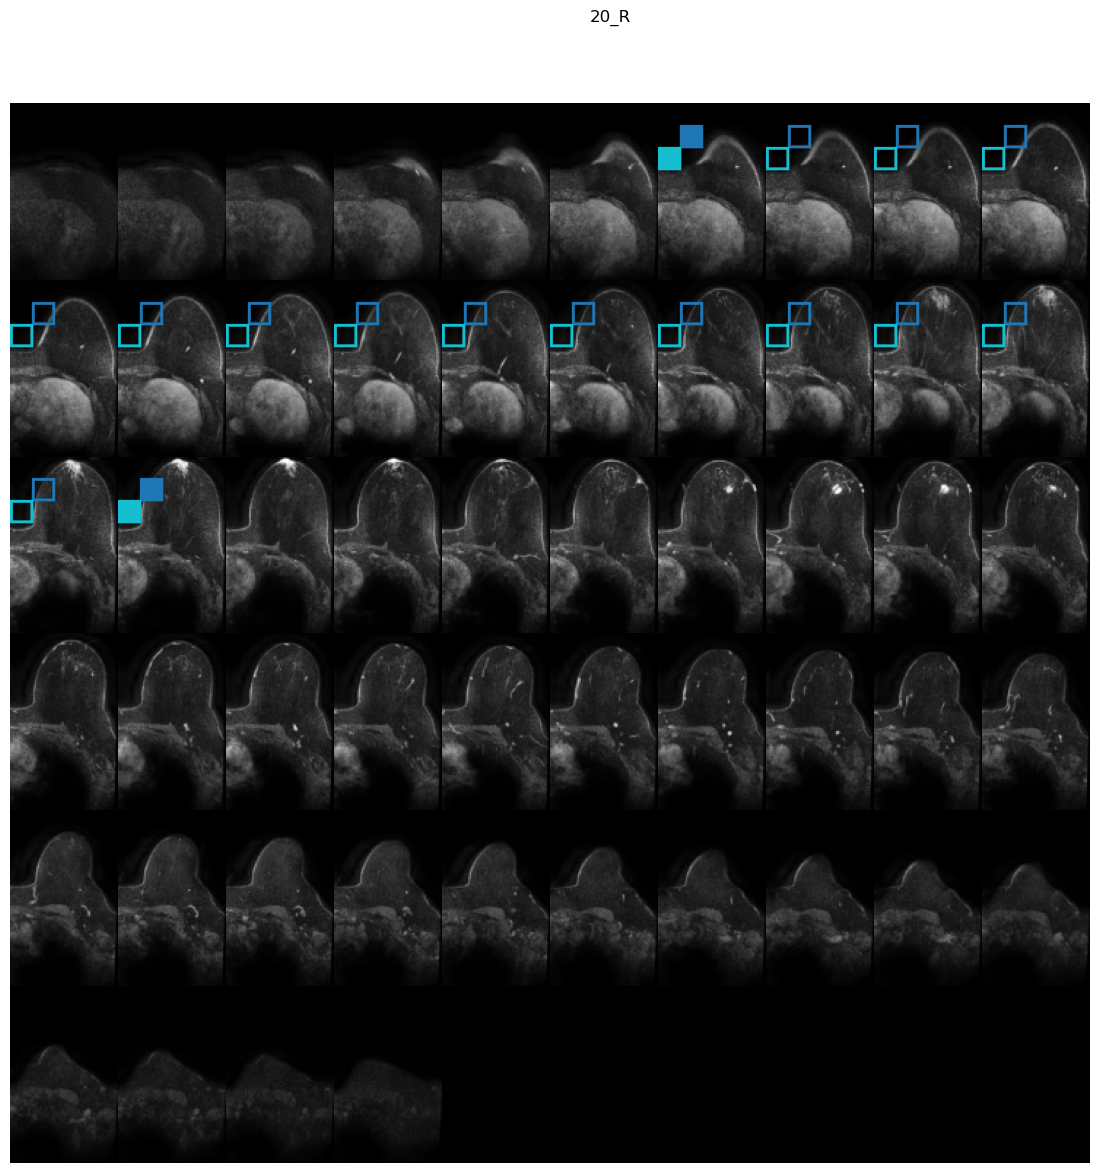

In [22]:
plt.clf()
plot_local_explanation(xs.unsqueeze(0), locExplanationsNonZero, title=patientKey)

In [56]:
volume=arr
volumeRGB=np.moveaxis(volume,[0,1,2,3],[-1,0,1,2])

sliceViewer(volumeRGB,[i for i in range(len(volumeRGB))],key="Depth",title="test",height=700)

In [23]:
### implement plot_local_explanation with the SliceViewer

## hopefully we can tack on a legend
def plot_local_explanationNew(xs, local_explanation, title=""):
    """
    Mark all the detected relevant prototypes in xs with a volume of 
    interest 
    
    
    Args:
        - xs: torch.Tensor, shape (bs,ch,D,H,W)
        - local_explanation: dict containing all the detected prototypes for 
          the input passed, where:
              -
              - key: int, index which identity the detected prototype
              - value: tuple containing:
                  - (dmin,dmax,hmin,hmax,wmin,wmax): tuple of the coordinates
                    in input image of the detected prototype
                  - simweight: contribution of the detected prototype to the
                    class predicted
         - title: str """
    
    num_ps = len(local_explanation.keys())
    rgb_colors = generate_rgb_array(num_ps)
    ps_scores = []

    xsCopy=xs.clone()

    for i, (ps_idx, ps) in enumerate(local_explanation.items()):
        
        ps_coord = ps[0]
        ps_score = ps[1]
        ps_scores.append((ps_score, rgb_colors[i]))
        
        d_min = ps_coord[0]
        d_max = ps_coord[1]
        h_min = ps_coord[2]
        h_max = ps_coord[3]
        w_min = ps_coord[4]
        w_max = ps_coord[5]
        
        # Create a binary mask for the cube's edges
        edges_mask_r = torch.zeros_like(xs)
        erosion_mask_r = torch.zeros_like(xs)
        
        edges_mask_g = torch.zeros_like(xs)
        erosion_mask_g = torch.zeros_like(xs)
        
        edges_mask_b = torch.zeros_like(xs)
        erosion_mask_b = torch.zeros_like(xs)
        
        edges_mask_r[:, 0, d_min:d_max+1, h_min:h_max+1, w_min:w_max+1] = 1
        erosion_mask_r[:, 0, d_min+1:d_max, h_min+2:h_max-2, w_min+2:w_max-1] = 1
        edges_mask_r = edges_mask_r - erosion_mask_r
        edges_mask_r = (edges_mask_r > 0).to(dtype=torch.bool)
        
        edges_mask_g[:, 1, d_min:d_max+1, h_min:h_max+1, w_min:w_max+1] = 1
        erosion_mask_g[:, 1, d_min+1:d_max, h_min+2:h_max-1, w_min+2:w_max-1] = 1
        edges_mask_g = edges_mask_g - erosion_mask_g
        edges_mask_g = (edges_mask_g > 0).to(dtype=torch.bool)
        
        edges_mask_b[:, 2, d_min:d_max+1, h_min:h_max+1, w_min:w_max+1] = 1
        erosion_mask_b[:, 2, d_min+1:d_max, h_min+2:h_max-1, w_min+2:w_max-1] = 1
        edges_mask_b = edges_mask_b - erosion_mask_b
        edges_mask_b = (edges_mask_b > 0).to(dtype=torch.bool)
        
        xsCopy[edges_mask_r] = rgb_colors[i][0]
        xsCopy[edges_mask_g] = rgb_colors[i][1]
        xsCopy[edges_mask_b] = rgb_colors[i][2]
    xsCopy=xsCopy[0].numpy()
    volumeRGB=np.moveaxis(xsCopy,[0,1,2,3],[-1,0,1,2])
    return sliceViewer(volumeRGB,[i for i in range(len(volumeRGB))],key="Depth",title=title,height=700)

In [24]:
plot_local_explanationNew(xs.unsqueeze(0), locExplanationsNonZero, title=patientKey)

In [76]:
#helper for this notebook, not complete in scope preservation

def gradient_explanation(key="20_R",topKProtos=[410,],thresh=.5):
    arr,label=projectloader.dataset[key]
    xs=arr.unsqueeze(0).to(device)
    xs.requires_grad=True
    features = net.module._net(xs)
    proto_features = net.module._add_on(features) #does any form of gradient accrue on features here?
    proto_features=proto_features.detach().cpu()
    protoThresh=proto_features > thresh
    gradients=[]
    for proto in topKProtos:
        releventIndices=[(i,j,k) for i in range(features.shape[2]) for j in range(features.shape[3]) for k in range(features.shape[4]) if protoThresh[0][proto][i][j][k]==1]
        if len(releventIndices)>0:
            
            i,j,k=releventIndices[0]
            gradient=torch.autograd.grad(features[0][proto][i][j][k],xs,retain_graph=True)[0]
            for i,j,k in releventIndices[1:]:
                gradient+=torch.autograd.grad(features[0][proto][i][j][k],xs,retain_graph=True)[0]
            gradient=gradient[0].detach().cpu().numpy()
            gradients.append(gradient)
    return gradients



In [80]:
def plot_gradient_explanation(key="20_R",topKProtos=[410,],thresh=.5,title="grad explanation",height=1200):    
    gradients=gradient_explanation(key=key,topKProtos=topKProtos,thresh=thresh)
    volumeRGB=np.moveaxis(gradients[0],[0,1,2,3],[-1,0,1,2])
    return sliceViewer(volumeRGB,[i for i in range(len(volumeRGB))],key="Depth",title=title,height=height)

In [81]:
plot_gradient_explanation()

In [ ]:
def overlap_gradient_naive(key="20_R",topKProtos=[410,],thresh=.5,title="overlap explanation"):
    

In [86]:
#helper for this notebook, not complete in scope preservation

def gradient_explanation_new(key="20_R",topKProtos=[410,],thresh=.5):
    arr,label=projectloader.dataset[key]
    xs=arr.unsqueeze(0).to(device)
    xs.requires_grad=True
    features = net.module._net(xs)
    proto_features = net.module._add_on(features) #does any form of gradient accrue on features here?
    proto_features=proto_features.detach().cpu()
    protoThresh=proto_features > thresh
    gradients=[]
    for proto in topKProtos:
        releventIndices=[(i,j,k) for i in range(features.shape[2]) for j in range(features.shape[3]) for k in range(features.shape[4]) if protoThresh[0][proto][i][j][k]==1]
        if len(releventIndices)>0:
            
            i,j,k=releventIndices[0]
            ijkVec=torch.tensor([features[0][p][i][j][k] for p in topKProtos if p!=proto])

            #gradient=torch.autograd.grad(features[0][proto][i][j][k],xs,retain_graph=True)[0]
            gradient=torch.autograd.grad(features[0][proto][i][j][k]-torch.log(torch.sum(torch.exp(ijkVec))),xs,retain_graph=True)[0]
            
            for i,j,k in releventIndices[1:]:

                #gradient+=torch.autograd.grad(features[0][proto][i][j][k],xs,retain_graph=True)[0]
                ijkVec=torch.tensor([features[0][p][i][j][k] for p in topKProtos if p!=proto])
                gradient+=torch.autograd.grad(features[0][proto][i][j][k]-torch.log(torch.sum(torch.exp(ijkVec))),xs,retain_graph=True)[0]
            gradient=gradient[0].detach().cpu().numpy()
            gradients.append(gradient)
    return gradients


def plot_gradient_explanation_new(key="20_R",topKProtos=[410,],thresh=.5,title="grad explanation",height=1200):    
    gradients=gradient_explanation_new(key=key,topKProtos=topKProtos,thresh=thresh)
    volumeRGB=np.moveaxis(gradients[0],[0,1,2,3],[-1,0,1,2])
    return sliceViewer(volumeRGB,[i for i in range(len(volumeRGB))],key="Depth",title=title,height=height)


In [87]:
plot_gradient_explanation_new()

In [107]:
#helper for this notebook, not complete in scope preservation


def gradient_patchResize(key="20_R",topKProtos=[410,],thresh=.5,greyscaleGrad=True):

    arr,label=projectloader.dataset[key]
    transform=Compose([Resize(spatial_size=arr.shape[1:],mode="nearest")])
    print(f"resizeShape {arr.shape[1:]}")
    xs=arr.unsqueeze(0).to(device)
    xs.requires_grad=True
    features = net.module._net(xs)
    proto_features = net.module._add_on(features) #does any form of gradient accrue on features here?
    proto_features=proto_features.detach().cpu()
    protoThresh=proto_features > thresh
    gradients=dict()
    patches=dict()
    print(f"protoThresh dim {protoThresh.shape}")
    for proto in topKProtos:
        #patches.append(Resize(protoThresh[0][proto],spatial_size=xs.shape[1:],mode='nearest'))
        patchResize=transform(protoThresh[0][proto].unsqueeze(0))[0].detach().cpu().numpy()
        #patchResize=(patchResize>.001).to(dtype=torch.bool)
        """
        xind,yind,zind = np.where(patchResize>.001) 
        d_min=np.min(xind)
        d_max=np.max(xind)
        h_min=np.min(yind)
        h_max=np.max(yind)
        w_min=np.min(zind)
        w_max=np.max(zind)
        edges_mask = torch.zeros_like(patchResize)
        erosion_mask = torch.zeros_like(patchResize)
        edges_mask[:, 0, d_min:d_max+1, h_min:h_max+1, w_min:w_max+1] = 1
        erosion_mask[:, 0, d_min+1:d_max, h_min+2:h_max-2, w_min+2:w_max-1] = 1
        edges_mask = edges_mask - erosion_mask
        edges_mask = (edges_mask > 0).to(dtype=torch.bool)
        
        patchResize[edges_mask] = 1
        ##^^^wrong approach
        """
        erosion_mask=binary_erosion(patchResize)


        #patches.append(patchResize)
        patches[proto]=patchResize-erosion_mask

        releventIndices=[(i,j,k) for i in range(features.shape[2]) for j in range(features.shape[3]) for k in range(features.shape[4]) if protoThresh[0][proto][i][j][k]==1]
        if len(releventIndices)>0:
            
            i,j,k=releventIndices[0]
            ijkVec=torch.tensor([features[0][p][i][j][k] for p in topKProtos if p!=proto])

            #gradient=torch.autograd.grad(features[0][proto][i][j][k],xs,retain_graph=True)[0]
            gradient=torch.autograd.grad(features[0][proto][i][j][k]-torch.log(torch.sum(torch.exp(ijkVec))),xs,retain_graph=True)[0]
            
            for i,j,k in releventIndices[1:]:

                #gradient+=torch.autograd.grad(features[0][proto][i][j][k],xs,retain_graph=True)[0]
                ijkVec=torch.tensor([features[0][p][i][j][k] for p in topKProtos if p!=proto])
                gradient+=torch.autograd.grad(features[0][proto][i][j][k]-torch.log(torch.sum(torch.exp(ijkVec))),xs,retain_graph=True)[0]
            gradient=gradient[0].detach().cpu().numpy()
            #absolute val + normalization
            gradient=np.abs(gradient)
            gradient=(gradient-gradient.min())/(gradient.max()-gradient.min())
            #print(f"gradientshape {gradient.shape}")
            if greyscaleGrad:
                gradient=np.array([gradient.mean(axis=0) for c in range(3)])

            gradients[proto]=gradient


    return gradients,patches


def plot_gradient_patchResize(key="20_R",topKProtos=[410,],thresh=.5,title="grad explanation",height=1200):    
    gradients,patches=gradient_patchResize(key=key,topKProtos=topKProtos,thresh=thresh)
    volumeRGB=np.moveaxis(gradients[topKProtos[0]].copy(),[0,1,2,3],[-1,0,1,2])
    print(f"volumeRGB shape {volumeRGB.shape}")

    ##make patches red for now
    cmap=[(1,0,0),(0,1,0),(0,0,1)] #TODO use some other gen 
    
    patch=patches[topKProtos[0]]
    patchRGB=np.array([cmap[0 % len(cmap)][j]*patch for j in range(3)])
    patchRGB=np.moveaxis(patchRGB,[0,1,2,3],[-1,0,1,2])
    print(f"patchRGB shape {patchRGB.shape}\t{np.any(patchRGB>.001)}")
    newVol=patchRGB+volumeRGB
    newVol=(newVol-newVol.min())/(newVol.max()-newVol.min())
    sliceViewers=[lambda : sliceViewer(newVol,[i for i in range(len(volumeRGB))],key="Depth",title=title,height=height)]
    #for k in topKProtos[1:]:

    return sliceViewers


In [108]:
gradients,patches=gradient_patchResize(key="20_R",topKProtos=[410,],thresh=.5)

resizeShape torch.Size([54, 121, 74])
protoThresh dim torch.Size([1, 512, 7, 8, 5])


In [106]:
gradients[410].mean(axis=0).shape

(54, 121, 74)

In [94]:
newVol.shape

(54, 121, 74, 3)

In [69]:
patches[410].shape

(54, 121, 74)

In [109]:
sliceViewers=plot_gradient_patchResize(key="20_R",topKProtos=[410,],thresh=.5,title="grad explanation",height=1200)

resizeShape torch.Size([54, 121, 74])
protoThresh dim torch.Size([1, 512, 7, 8, 5])
volumeRGB shape (54, 121, 74, 3)
patchRGB shape (54, 121, 74, 3)	True


In [110]:
sliceViewers[0]()

In [43]:
patches[0].shape

(54, 121, 74)

In [25]:
xs.shape

torch.Size([3, 54, 121, 74])

In [83]:
xs=arr.unsqueeze(0).to(device)
xs.requires_grad=True
features = net.module._net(xs)

gradTensor=torch.autograd.grad(features[0][0][0][0][0],xs,retain_graph=True)
gradTensor2=torch.autograd.grad(features[0][0][0][0][1],xs)

i,j,k=2,3,4

### find the indices of z,r,c within a given proto through softmax, then sum the gradient of the relevent


In [68]:
topkProtos=[26, 30, 58, 76, 80, 95, 137, 172, 189, 190, 196, 206, 211, 229, 236, 252, 278, 282, 303, 327, 347, 366, 372, 384, 424, 450, 452, 458, 479, 507, 509]

outputFile=f"{args['log_dir']}/featuresGradient.h5"

thresh=.5

with h5py.File(f'{outputFile}','w') as gradientData:
    #image -> protos -> gradient
    ###eventually throw in simweights in this dataset for both classes
   
    for key in inputKeys: 
        grp=gradientData.create_group(key)
        arr,label=projectloader.dataset[key]
        grp.attrs['classLabel']=label
        xs=arr.unsqueeze(0).to(device)
        xs.requires_grad=True
        features = net.module._net(xs)
        proto_features = net.module._add_on(features) #does any form of gradient accrue on features here?
        proto_features=proto_features.detach().cpu()
        protoThresh=proto_features > thresh

        for proto in topkProtos:
            releventIndices=[(i,j,k) for i in range(features.shape[2]) for j in range(features.shape[3]) for k in range(features.shape[4]) if protoThresh[0][proto][i][j][k]==1]
            if len(releventIndices)>0:
                
                i,j,k=releventIndices[0]
                #ijkVec=torch.tensor([features[0][p][i][j][k] for p in topkProtos if p!=proto])

                gradient=torch.autograd.grad(features[0][proto][i][j][k],xs,retain_graph=True)[0]
                for i,j,k in releventIndices[1:]:
                    gradient+=torch.autograd.grad(features[0][proto][i][j][k],xs,retain_graph=True)[0]
                gradient=gradient.detach().cpu().numpy()
                grp.create_dataset(f"proto{proto}",data=gradient[0],compression="gzip", compression_opts=6)


        

KeyboardInterrupt: 

In [82]:
torch.tensor([5])

tensor([5])